In [1]:
%matplotlib inline

import networkx as nx
from networkx.algorithms import community, bridges, smallworld
import numpy as np
import matplotlib.pyplot as plt

import collections

from scipy import stats

import imageio

import time

from IPython.display import Image, Audio

import copy

from tqdm import tnrange, tqdm_notebook

np.random.seed(0)

In [5]:
lower = 0
upper = 250
mu = upper / 2
sigma = np.sqrt(upper) / 2

thresh = 0.95

prob_adopted = 0.3

iters = 500

vec_len = 1

neighbor_pref = 0.8

neighbor_threshold = 0.1

product_adoption_jitter = sigma

make_gif = False

calc_omega = False

ims = []

product_dist = stats.truncnorm((lower - mu)/sigma, (upper - mu)/sigma, loc=mu, scale=sigma)
# schelling_dist = stats.truncnorm((0 - 0.5)/0.15, (1 - 0.5)/0.15, loc=0.5, scale=0.25)

def random_product():
    return np.random.choice([np.random.rand()*upper, -1], p=[prob_adopted, 1 - prob_adopted])

def random_product_vec():
    return [random_product() for _ in range(vec_len)]

def gauss_random_product():
    return np.random.choice([product_dist.rvs(), -1], p=[prob_adopted, 1 - prob_adopted])

def random_schelling():
    return np.random.rand() * (upper / 8)

init = 10

G = nx.connected_watts_strogatz_graph(init, 3, np.random.rand())

products = dict([(i, random_product_vec()) for i in range(init)])
thresholds = dict([(i, np.random.rand()) for i in range(init)])
schellings = dict([(i, random_schelling()) for i in range(init)])

nx.set_node_attributes(G, products, 'apt_markakis')
nx.set_node_attributes(G, thresholds, 'threshold')
nx.set_node_attributes(G, schellings, 'schelling')

attrs = [np.average(nx.get_node_attributes(G, 'apt_markakis')[i]) for i in G]



In [6]:
def barabasi_step(graph):
    for _ in range(np.random.choice(4, p=[0.55, 0.3, 0.1, 0.05])):
        tot = graph.number_of_edges() * 2
        probs = [val / tot for (_, val) in graph.degree()]
        rands = np.random.uniform(size=len(probs))
        check = [rands[i] <= probs[i] for i in range(len(probs))]
        while not True in check:
            rands = np.random.uniform(size=len(probs))
            check = [rands[i] <= probs[i] for i in range(len(probs))]
        new_prod = random_product_vec()
        graph.add_node(len(rands), apt_markakis = new_prod, schelling = random_schelling(), threshold=np.random.rand())
        graph.add_edges_from([(len(rands), i) for i in range(len(rands)) if check[i]])
    
def threshold_met(graph, node):
    neighbors = [graph.node[x]['apt_markakis'] for x in graph[node]]
    if neighbors:
        return (sum([1 for x in neighbors if x > -1]) / len(neighbors)) > graph.node[node]['threshold']
    return False
   
def vec_threshold_met(graph, node):
    neighbors = [graph.node[x]['apt_markakis'] for x in graph[node]]
    met = []
    for i in range(vec_len):
        if (sum([1 for x in neighbors if list(x)[i] > -1]) / len(neighbors)) > graph.node[node]['threshold']:
            met.append(i)
    if met:
        return np.random.choice(met)
    return -1
    
def apt_markakis_step_med(graph):
    unset = [x for x in graph.nodes if any(i < 0 for i in graph.node[x]['apt_markakis'])]
    candidates = [(x, vec_threshold_met(graph, x)) for x in unset]
    candidates = [x for x in candidates if x[1] > -1]
    if candidates:
        tar, idx = candidates[np.random.choice(len(candidates))]
        neighbor_med = np.median([graph.node[x]['apt_markakis'][idx] for x in graph.nodes if graph.node[x]['apt_markakis'][idx] > -1])
        adopted = np.random.normal() * product_adoption_jitter + neighbor_med
        while adopted < 0:
            adopted = np.random.normal() * product_adoption_jitter + neighbor_med
        graph.node[tar]['apt_markakis'][idx] = adopted
        
def dist(l1, l2):
    l1 = np.array([l1[i] if l1[i] > -1 and l2[i] > -1 else 0 for i in range(len(l1))])
    l2 = np.array([l2[i] if l1[i] > -1 and l2[i] > -1 else 0 for i in range(len(l2))])
#     return np.sqrt(np.sum((l1 - l2)**2))
    return np.sum(np.abs(l1 - l2))
        
def unhappy(graph, node):
    neighbors = [graph.node[x]['apt_markakis'] for x in graph[node] if any(i > -1 for i in graph.node[x]['apt_markakis'])]
    if not neighbors:
        return False
    dif_neighbors = [x for x in neighbors if dist(graph.node[node]['apt_markakis'], x) > graph.node[node]['schelling']]
    return len(dif_neighbors) / len(neighbors) > neighbor_threshold

def neighbor_dist_avg(graph, node):
    neighbors = [graph.node[x]['apt_markakis'] for x in graph[node] if any(i > -1 for i in graph.node[x]['apt_markakis'])]
    if neighbors:
        return np.sum([dist(node, neighbor) for neighbor in neighbors]) / len(neighbors)
    return np.inf
    
def euclidian(graph, node, vec):
    return np.sum([dist(graph.node[node]['apt_markakis'], graph.node[neighbor]['apt_markakis']) for neighbor in vec]) / len(vec)
#     return np.sqrt(np.sum([(graph.node[neighbor]['apt_markakis'] - graph.node[node]['apt_markakis'])**2 for neighbor in vec])) / len(vec)
    
def schelling_step_avg(graph):
    adopted = [x for x in graph.nodes if any(i > -1 for i in graph.node[x]['apt_markakis'])]
    candidates = [x for x in adopted if unhappy(graph, x)]
    add_ctr = 0
    rem_ctr = 0
    if candidates:
        tar = np.random.choice(candidates)
        probs = [val for (_, val) in graph.degree()]
        tot = sum([np.e**x for x in probs])
        probs = [np.e**x / tot for x in probs]
        friends = list(set([n for i in G[tar] for n in G[i]]))
        friend_probs = [1 / (len(friends)) if x in friends else 0 for x in range(len(probs))]
        probs = [(1 - neighbor_pref) * probs[i] + neighbor_pref * friend_probs[i] for i in range(len(probs))]
        test_pts = np.random.choice(len(probs), p=probs, replace=False, size=len(probs))
        test_pts = [test for test in test_pts if any(i > -1 for i in graph.node[test]['apt_markakis'])]
        bs = list(bridges(graph))
        for test in test_pts:

            neighbors = [x for x in graph[tar] if any(i > -1 for i in graph.node[x]['apt_markakis'])]
            neighbor_dist = euclidian(graph, tar, neighbors)
            if graph.has_edge(test, tar) and (test, tar) not in bs and (tar, test) not in bs:
                neighbor_test = copy.deepcopy(neighbors)
                neighbor_test.remove(test)
                if euclidian(graph, tar, neighbor_test) / neighbor_dist < thresh:
                    graph.remove_edge(test, tar)
                    bs = list(bridges(graph))
                    rem_ctr += 1
            elif euclidian(graph, tar, neighbors + [test]) / neighbor_dist < thresh:
                graph.add_edge(test, tar)
                add_ctr += 1
            if not unhappy(graph, tar):
#                 print("broke", add_ctr, rem_ctr)
                break
#         print("finished", add_ctr, rem_ctr)
    return add_ctr, rem_ctr
    
def draw_attrs(graph):
    attrs = [np.average(nx.get_node_attributes(G, 'apt_markakis')[i]) for i in G.nodes]
    nx.draw(G, node_color=attrs, node_size=25)

In [7]:
adds = 0
rems = 0

for i in tnrange(iters, desc='executing model'):
    if make_gif:
        draw_attrs(G)
        fname = "images/frames/j_model" + str(i) + ".png"
        plt.savefig(fname)
        ims.append(fname)
        plt.cla()
        plt.clf()
    barabasi_step(G)
    for _ in range(20):
        apt_markakis_step_med(G)
        ra, rr = schelling_step_avg(G)
        adds += ra
        rems += rr
    
print(adds, rems)



4145 1525


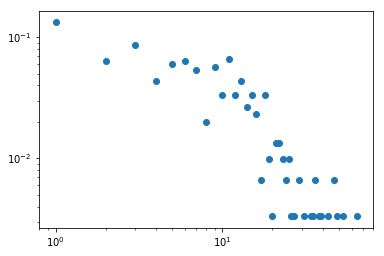

In [8]:
degree_sequence = [d for (n, d) in G.degree()]
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

tot = sum(cnt)
per = [c / tot for c in cnt]

plt.xscale('log')
plt.yscale('log')
plt.scatter(deg, per)

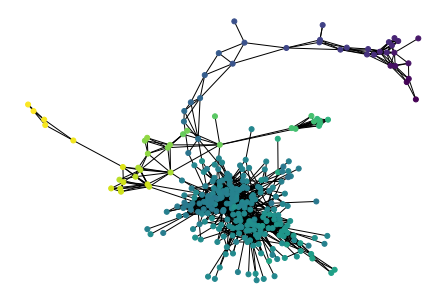

In [9]:
draw_attrs(G)
fname = "images/frames/final" + str(int(time.time())) + '.png'
plt.savefig(fname)

if make_gif:
#     plt.savefig("images/frames/j_model_final.png")
    ims.append(fname)

    files = []
    for im in ims:
        files.append(imageio.imread(im))

    gif_name = 'images/runs/' + str(int(time.time())) + '.gif'
    imageio.mimsave(gif_name, files, duration=0.3)
    
    with open(gif_name,'rb') as f:
        display(Image(data=f.read(), format='png'))

In [8]:
# c = list(community.asyn_fluidc(G, vals.index(max(vals)) + 1))

# for com in c:
#     attrs = [np.average(nx.get_node_attributes(G, 'apt_markakis')[i]) for i in com]
#     if len([x for x in attrs if x > -1]) > 0:
#         print(com, len(com), np.average([x for x in attrs if x >-1]))
#     else:
#         print(com, 0)
#     nx.draw(G.subgraph(com), node_color=attrs, node_size=25)
#     plt.show()

# print(len(c))

In [9]:
# for com1 in c:
#     for com2 in c:
#         attrs1 = [np.average(nx.get_node_attributes(G, 'apt_markakis')[i]) for i in com1]
#         attrs2 = [np.average(nx.get_node_attributes(G, 'apt_markakis')[i]) for i in com2]
#         if len([x for x in attrs1 if x > -1]) > 0 and len([x for x in attrs2 if x > -1]) > 0:
#             print(np.average([x for x in attrs1 if x >-1]), np.average([x for x in attrs2 if x >-1]))
#         else:
#             print(0, 0)
            
#         union = com1.union(com2)
#         attrsu = [np.average(nx.get_node_attributes(G, 'apt_markakis')[i]) for i in union]
#         nx.draw(G.subgraph(union), node_color=attrsu, node_size=25)
#         plt.show()

In [10]:
if calc_omega:
    omega = smallworld.omega(G)
    print(omega)